In [1]:
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

random.seed(1000)

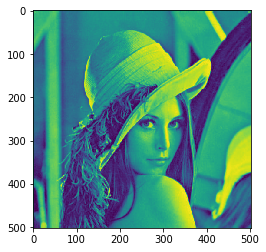

In [4]:
img = cv2.imread('../data/lena.bmp', 0)
imshow(img)
# cv2.imshow('image', img)
# key = cv2.waitKey()
# if key == 27:
#     cv2.destroyAllWindows()

In [3]:
print("image type: ", img.dtype)  # uint8 if python  elif c++ uchar
print("image shape: ", img.shape)

image type:  uint8
image shape:  (502, 502)


### 1、crop image

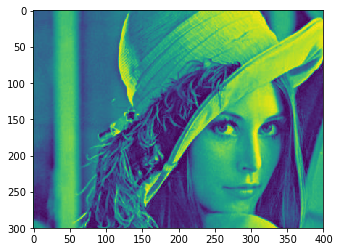

In [4]:
crop_img = img[100:400, :400]
imshow(crop_img)

### add a random noise for image

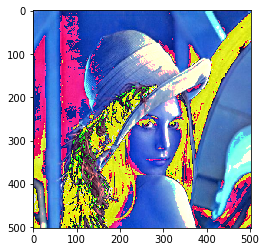

In [5]:
img_2 = cv2.imread('./data/lena.bmp', 1)
h, w, c = img_2.shape[0], img_2.shape[1], img_2.shape[2]  # (502, 502, 3)

def random_light_color(img):
    B, G, R = cv2.split(img)
    
    b_rand = random.randint(-50, 50)
    if b_rand == 0:
        pass
    elif b_rand > 0:
        lim = 255 - b_rand
        B[B > lim] = 255
        B[B < lim] = (lim + B[B < lim]).astype(img.dtype)
    elif b_rand < 0:
        lim = 255 + b_rand
        B[B < lim] = 0
        B[B > lim] = (lim + B[B > lim]).astype(img.dtype)
    
    r_rand = random.randint(-50, 50)
    if r_rand == 0:
        pass
    elif r_rand > 0:
        lim = 255 - r_rand
        R[R > lim] = 255
        R[R < lim] = (lim + R[R < lim]).astype(img.dtype)
    elif r_rand < 0:
        lim = 255 + r_rand
        R[R < lim] = 0
        R[R > lim] = (lim + R[R > lim]).astype(img.dtype)
    
    g_rand = random.randint(-50, 50)
    if g_rand == 0:
        pass
    elif g_rand > 0:
        lim = 255 - g_rand
        G[G > lim] = 255
        G[G < lim] = (lim + G[G < lim]).astype(img.dtype)
    elif g_rand < 0:
        lim = 255 + g_rand
        G[G < lim] = 0
        G[G > lim] = (lim + G[G > lim]).astype(img.dtype)
    
    img_merge = cv2.merge((B, G, R))
    return img_merge

imshow(random_light_color(img_2))

### change its light

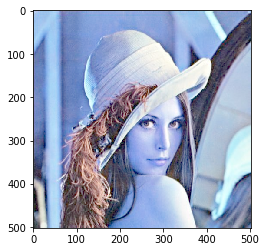

In [6]:
def adjust_gamma(image, gamma=1.0):
    inv_gamma = 1.0 / gamma
    table = []
    for i in range(256):
        table.append(((i / 255.0)**inv_gamma) * 255)
    table = np.array(table).astype("uint8")
    return cv2.LUT(image, table)

gamma = 2  # bigger -> more brighter
img_brighter = adjust_gamma(img_2, gamma)
imshow(img_brighter)

### image histogram

(array([ 109.,    0.,    0.,    0.,   38.,    0.,   32.,   21.,   31.,
          39.,   10.,   34.,   31.,   33.,   29.,   29.,   51.,   48.,
          42.,   38.,   54.,   52.,   50.,   64.,   62.,   57.,   61.,
          68.,   70.,   74.,   77.,   95.,  100.,  103.,  102.,  120.,
         116.,  120.,  118.,  137.,  139.,  154.,  149.,  168.,  188.,
         231.,  190.,  234.,  216.,  235.,  289.,  272.,  303.,  336.,
         319.,  348.,  382.,  374.,  385.,  433.,  430.,  457.,  429.,
         471.,  484.,  465.,  526.,  518.,  557.,  479.,  576.,  569.,
         638.,  587.,  620.,  605.,  621.,  598.,  642.,  623.,  652.,
         604.,  657.,  594.,  610.,  618.,  575.,  559.,  601.,  574.,
         567.,  576.,  582.,  604.,  563.,  607.,  604.,  643.,  613.,
         628.,  679.,  694.,  703.,  676.,  738.,  698.,  711.,  676.,
         689.,  706.,  722.,  685.,  675.,  647.,  615.,  608.,  617.,
         612.,  629.,  628.,  600.,  665.,  653.,  724.,  666.,  723.,
      

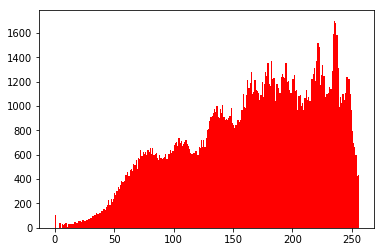

In [7]:
img_small_brighter = cv2.resize(img_brighter,
                                (int(h*0.5), int(w*0.5)))
plt.hist(img_small_brighter.flatten(), 256, [0, 256], color='r')

### y: luminance(明亮度)    u&v: 色度饱和度

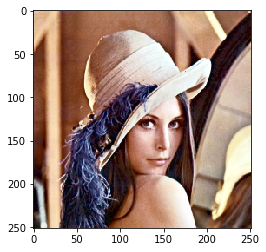

In [8]:
img_yuv = cv2.cvtColor(img_small_brighter, cv2.COLOR_BGR2YUV)
img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])  # only for 1 channel
img_out = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
imshow(img_out)

### similarity transform = scale + rotation + translation
保持平行线和垂直线  (不让直线弯曲)

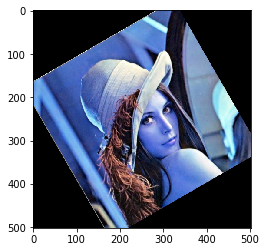

In [12]:
M = cv2.getRotationMatrix2D((h/2, w/2), 30, 0.8)  # center  angle  scale
img_rotate = cv2.warpAffine(img_2, M, (int(w), int(h)))
imshow(img_rotate)

### Affine Transform
保持平行线， 不保持垂直线  (不让直线弯曲)     需要 3 个点获得 4 个参数解

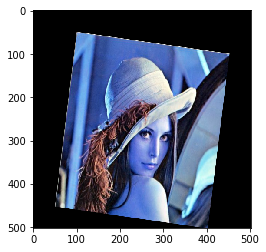

In [10]:
# 3 points
pts1 = np.float32([[0, 0], [w-1, 0], [0, h-1]])
pts2 = np.float32([[w*0.2, h*0.1], [w*0.9, h*0.2], [w*0.1, h*0.9]])

M = cv2.getAffineTransform(pts1, pts2)
img_affine = cv2.warpAffine(img_2, M, (w, h))

imshow(img_affine)

### perspective transform (投影变换)
既不保持垂直线，也不保持平行线 (不让直线弯曲)  需要 4 对点获取 9 个变换参数

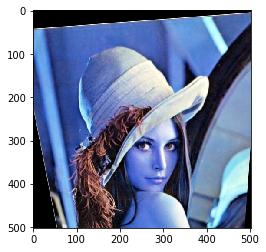

In [11]:
def random_warp(img, row, col, random_margin=60):
    h, w, c = img.shape
    rm = random_margin
    
    # 4 pairs 
    x1 = random.randint(-rm, rm)
    y1 = random.randint(-rm, rm)
    dx1 = random.randint(-rm, rm)
    dy1 = random.randint(-rm, rm)
    
    x2 = random.randint(w - rm - 1, w - 1)
    y2 = random.randint(-rm, rm)
    dx2 = random.randint(w - rm - 1, w - 1)
    dy2 = random.randint(-rm, rm)
    
    x3 = random.randint(w - rm - 1, w - 1)
    y3 = random.randint(h - rm - 1, h - 1)
    dx3 = random.randint(w - rm - 1, w - 1)
    dy3 = random.randint(h - rm - 1, h - 1)
    
    x4 = random.randint(-rm, rm)
    y4 = random.randint(h - rm - 1, h - 1)
    dx4 = random.randint(-rm, rm)
    dy4 = random.randint(h - rm - 1, h - 1)
    
    pts1 = np.float32([[x1, y1], [x2, y2], [x3, y3], [x4, y4]])
    pts2 = np.float32([[dx1, dy1], [dx2, dy2], [dx3, dy3], [dx4, dy4]])
    M = cv2.getPerspectiveTransform(pts1, pts2)
    
    return M, cv2.warpPerspective(img, M, (w, h))

M_per, img_per = random_warp(img_2, w, h)
imshow(img_per)